In [117]:
# Core libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
import pandas as pd

# Skimage for morphological operations and region properties
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.measure import label, regionprops

# Sklearn for classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Number of images per class
from collections import Counter

In [292]:
# Colab-specific for mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading dataset

In [ ]:
def load_dataset_with_mask_offset(images_dir, masks_dir):
    dataset = []
    classes = sorted(os.listdir(images_dir))
    print("Detected classes:", classes)

    for cls in classes:
        img_folder = os.path.join(images_dir, cls)
        mask_folder = os.path.join(masks_dir, cls)

        img_files = sorted(os.listdir(img_folder))
        mask_files = sorted(os.listdir(mask_folder))

        if len(img_files) != len(mask_files):
            print(f"Warning: Image/mask count mismatch in class {cls}")

        # Pair by index (first image -> first mask)
        for i in range(len(img_files)):
            dataset.append({
                'class': cls,
                'img_path': os.path.join(img_folder, img_files[i]),
                'mask_path': os.path.join(mask_folder, mask_files[i])
            })

    print(f"Total images loaded: {len(dataset)}")
    return dataset

In [ ]:
!ls /content/drive/MyDrive/Segmentation_IoU_Classification/masks

_Ground_Truth_Masked


In [ ]:
IMAGES_DIR='/content/drive/MyDrive/Segmentation_IoU_Classification/images'
MASKS_DIR='/content/drive/MyDrive/Segmentation_IoU_Classification/masks/_Ground_Truth_Masked'
dataset = load_dataset_with_mask_offset(IMAGES_DIR, MASKS_DIR)

Detected classes: ['Alstonia_(P0)', 'Arjun_(P1)', 'Basil_(P2)', 'Chinar_(P3)', 'Jamun_(P4)', 'Jatropha_(P5)', 'Lemon_(P6)', 'Mango_(P7)', 'Pomegranate_(P8)', 'Pongamia_Pinnata_(P9)']
Total images loaded: 1971


In [23]:
# Check first 3 entries
dataset[:3]

[{'class': 'Alstonia_(P0)',
  'img_path': '/content/drive/MyDrive/Segmentation_IoU_Classification/images/Alstonia_(P0)/0003_0001.JPG',
  'mask_path': '/content/drive/MyDrive/Segmentation_IoU_Classification/masks/_Ground_Truth_Masked/Alstonia_(P0)/0003_0001.JPG'},
 {'class': 'Alstonia_(P0)',
  'img_path': '/content/drive/MyDrive/Segmentation_IoU_Classification/images/Alstonia_(P0)/0003_0002.JPG',
  'mask_path': '/content/drive/MyDrive/Segmentation_IoU_Classification/masks/_Ground_Truth_Masked/Alstonia_(P0)/0003_0002.JPG'},
 {'class': 'Alstonia_(P0)',
  'img_path': '/content/drive/MyDrive/Segmentation_IoU_Classification/images/Alstonia_(P0)/0003_0003.JPG',
  'mask_path': '/content/drive/MyDrive/Segmentation_IoU_Classification/masks/_Ground_Truth_Masked/Alstonia_(P0)/0003_0003.JPG'}]

In [27]:
# Total number of images
print(f"Total images in dataset: {len(dataset)}")

class_counts = Counter([sample['class'] for sample in dataset])
print("Number of images per class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Image size statistics
heights, widths = [], []

for sample in dataset[:3]:
    img = cv2.imread(sample['img_path'])
    h, w = img.shape[:2]
    heights.append(h)
    widths.append(w)

print(f"\nImage size statistics:")
print(f" - Height: min={min(heights)}, max={max(heights)}, mean={int(np.mean(heights))}")
print(f" - Width:  min={min(widths)}, max={max(widths)}, mean={int(np.mean(widths))}")


Total images in dataset: 1971
Number of images per class:
Alstonia_(P0): 174
Arjun_(P1): 214
Basil_(P2): 148
Chinar_(P3): 103
Jamun_(P4): 267
Jatropha_(P5): 131
Lemon_(P6): 159
Mango_(P7): 170
Pomegranate_(P8): 286
Pongamia_Pinnata_(P9): 319

Image size statistics:
 - Height: min=400, max=400, mean=400
 - Width:  min=600, max=600, mean=600


Segmentation

In [52]:
def segment_leaf_image(img):
    """
    Input: raw RGB leaf image
    Output: binary mask (white leaf, black background)
    """
    # Step 1: Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Step 2: Contrast enhancement (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    contrast = clahe.apply(gray)

    # Step 3: Denoise (median filter)
    denoised = cv2.medianBlur(contrast, 5)

    # Step 4: Thresholding (Otsu)
    _, binary = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)#0-255,otsu method
    h, w = binary.shape
    corners = [binary[0,0], binary[0, w-1], binary[h-1, 0], binary[h-1, w-1]]

    # Step 5: Ensure leaf is white
    if np.mean(corners) > 127:
        binary = cv2.bitwise_not(binary) #convert

    # Step 6: Contour-Based Masking
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a blank mask
    predicted_mask = np.zeros_like(binary)

    if contours:
        # Find the largest contour
        largest_contour = max(contours, key=cv2.contourArea)

        # Draw the contour filled (thickness = -1 fills the interior)
        cv2.drawContours(predicted_mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    return predicted_mask

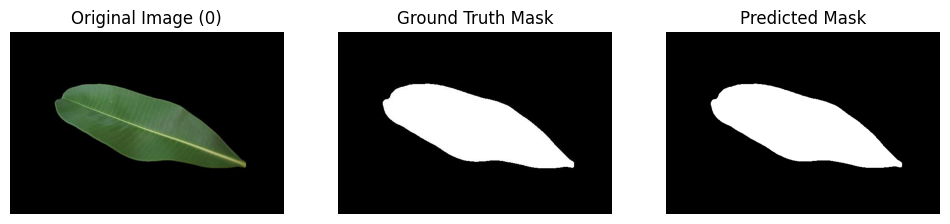

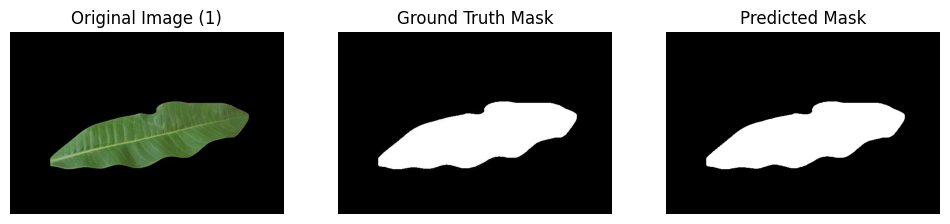

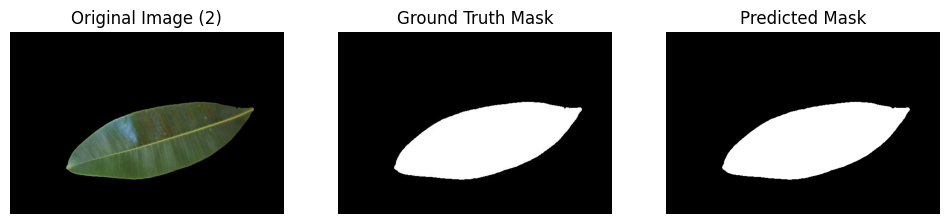

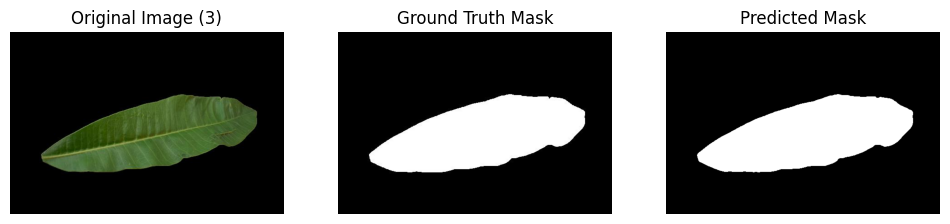

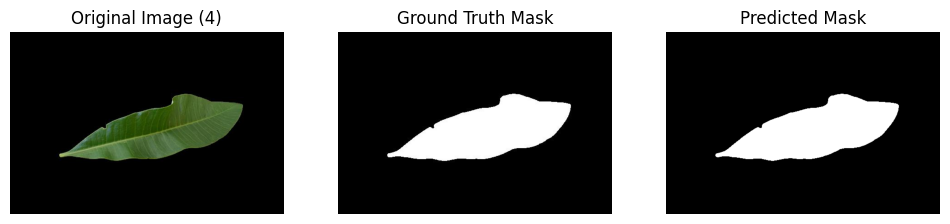

In [53]:
start_idx = 0
end_idx = 5

for i in range(start_idx, end_idx):
    sample = dataset[i]

    # Load image and ground truth mask
    img = cv2.imread(sample['img_path'])
    gt_mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)

    # Segment leaf
    pred_mask = segment_leaf_image(img)

    # Visualization
    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Original Image ({i})")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap="gray")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

Evaluate (IOU)

In [54]:
def jaccard_index(pred, gt):
    """
    Compute the Jaccard Index (IoU) between two boolean masks.

    Args:
        pred: predicted mask (boolean array)
        gt: ground truth mask (boolean array)

    Returns:
        IoU value between 0 and 1
    """
    pred = pred.astype(bool)
    gt = gt.astype(bool)

    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()

    if union == 0:
        return 0.0

    return intersection / union

def compute_iou_dataset(dataset, pred_base_dir):

    iou_list = []

    for sample in dataset:
        gt_mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)

        # Construct path to predicted mask
        pred_mask_path = os.path.join(pred_base_dir, sample['class'], os.path.basename(sample['img_path']))
        pred_mask = cv2.imread(pred_mask_path, cv2.IMREAD_GRAYSCALE)

        iou = jaccard_index(pred_mask > 0, gt_mask > 0)
        iou_list.append(iou)

    avg_iou = np.mean(iou_list)
    print(f"Average IoU over dataset: {avg_iou:.4f}")
    return iou_list, avg_iou

In [55]:
# Base folder in Google Drive
LOCAL_DIR = "/content/Predicted_Mask"
SAVE_DIR = '/content/drive/MyDrive/Segmentation_IoU_Classification/masks/Predicted_Mask'
os.makedirs(LOCAL_DIR, exist_ok=True)
for sample in tqdm(dataset):
    img = cv2.imread(sample['img_path'])
    pred_mask = segment_leaf_image(img)

    # Extract class folder from img_path
    class_folder = sample['class']  # e.g., 'Alstonia_(P0)'
    save_folder = os.path.join(BASE_DIR, class_folder)
    os.makedirs(save_folder, exist_ok=True)

    # Save predicted mask with same filename
    filename = os.path.basename(sample['img_path'])
    save_path = os.path.join(save_folder, filename)
    success = cv2.imwrite(save_path, pred_mask)

    if not success:
        print(f"Failed to save: {save_path}")
save_path = os.path.join(SAVE_DIR, class_folder, filename)

100%|██████████| 1971/1971 [00:55<00:00, 35.25it/s]


In [58]:
LOCAL_DIR = "/content/Predicted_Mask"
os.makedirs(LOCAL_DIR, exist_ok=True)

for sample in tqdm(dataset):
    img = cv2.imread(sample['img_path'])
    pred_mask = segment_leaf_image(img)

    class_folder = sample['class']
    save_folder = os.path.join(LOCAL_DIR, class_folder)
    os.makedirs(save_folder, exist_ok=True)

    filename = os.path.basename(sample['img_path'])
    save_path = os.path.join(save_folder, filename)

    success = cv2.imwrite(save_path, pred_mask)
    if not success:
        print(f"Failed to save: {save_path}")

100%|██████████| 1971/1971 [00:29<00:00, 67.86it/s]


In [59]:
dir='/content/Predicted_Mask'
# Compute IoU for the entire dataset
iou_list, avg_iou = compute_iou_dataset(dataset, dir)

print(f"Average IoU across all images: {avg_iou:.4f}")
print(f"Minimum IoU: {np.min(iou_list):.4f}")
print(f"Maximum IoU: {np.max(iou_list):.4f}")

Average IoU over dataset: 0.9427
Average IoU across all images: 0.9427
Minimum IoU: 0.7919
Maximum IoU: 0.9769


In [62]:
# Get indices of the lowest IoU values
sorted_indices = np.argsort(iou_list)

# Take the worst 5 cases
worst_indices = sorted_indices[:5]

worst_indices

array([1484,  187, 1435, 1438, 1433])

Class: Pomegranate_(P8)
IoU: 0.7919


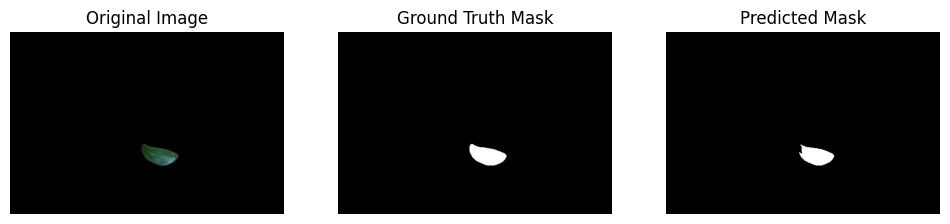

Class: Arjun_(P1)
IoU: 0.8040


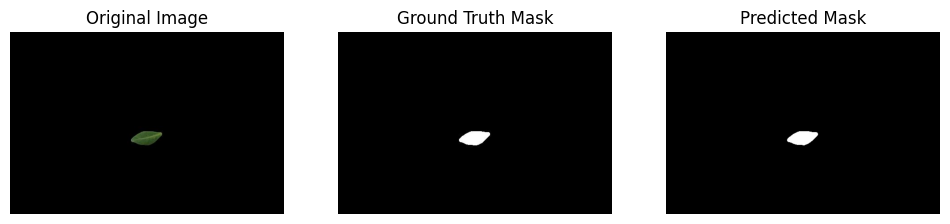

Class: Pomegranate_(P8)
IoU: 0.8141


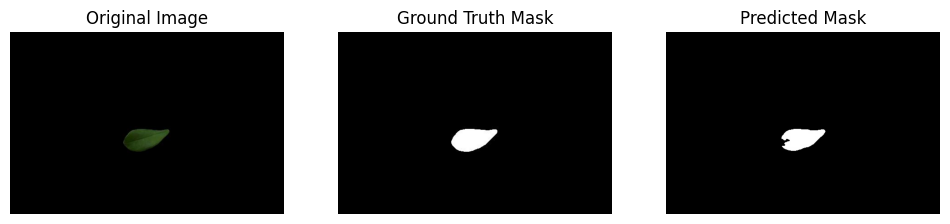

Class: Pomegranate_(P8)
IoU: 0.8173


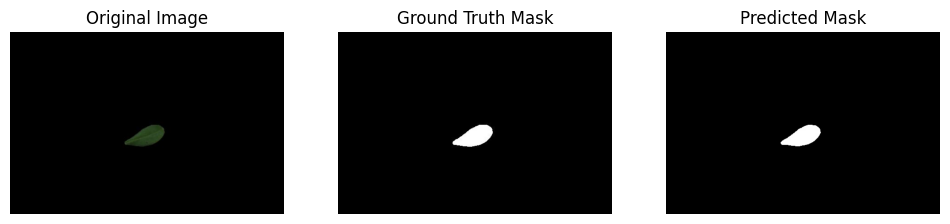

Class: Pomegranate_(P8)
IoU: 0.8205


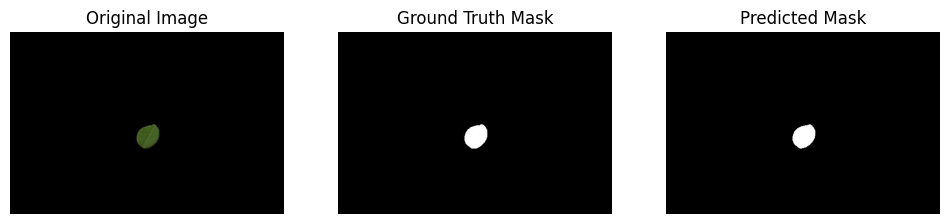

In [64]:
PRED_DIR = '/content/Predicted_Mask'

for idx in worst_indices:
    sample = dataset[idx]

    img = cv2.imread(sample['img_path'])
    gt_mask = cv2.imread(sample['mask_path'], cv2.IMREAD_GRAYSCALE)

    pred_path = os.path.join(
        PRED_DIR,
        sample['class'],
        os.path.basename(sample['img_path'])
    )
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    print(f"Class: {sample['class']}")
    print(f"IoU: {iou_list[idx]:.4f}")

    plt.figure(figsize=(12,4))

    plt.subplot(1,3,1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

In [65]:
SAVE_DIR = "/content/drive/MyDrive/Segmentation_IoU_Classification/masks/Predicted_Mask"
!cp -r /content/Predicted_Mask "$SAVE_DIR"

Extract Features

In [104]:
def extract_features(mask):

    # Ensure mask is strictly binary (0 and 1)
    mask = (mask > 0).astype(int)

    # Label connected regions
    labeled = label(mask)
    regions = regionprops(labeled)

    # Return None if no regions found
    if not regions:
        return None

    # Select the largest region (assumed to be the main leaf)
    leaf = max(regions, key=lambda r: r.area)

    # ---------- Geometric Features ----------
    area = leaf.area                # number of pixels in leaf
    perimeter = leaf.perimeter      # length of leaf boundary
    convex_area = leaf.convex_area  # area of convex hull around leaf

    # Bounding box
    minr, minc, maxr, maxc = leaf.bbox
    height = maxr - minr
    width = maxc - minc

    # Aspect ratio: width divided by height (leaf elongation)
    aspect_ratio = width / (height + 1e-6)

    # Shape descriptors
    circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)
    compactness = area / (perimeter**2 + 1e-6)
    convexity = area / (convex_area + 1e-6)

    # ---------- Hu Moments ----------
    # Compute moments
    moments = cv2.moments(mask.astype(np.uint8))
    hu_moments = cv2.HuMoments(moments).flatten()

    # Log-transform Hu moments to make them more readable for classifiers
    hu_log = []
    for h in hu_moments:
        if h == 0:
            hu_log.append(0)
        else:
            hu_log.append(-1 * math.copysign(1.0, h) * math.log10(abs(h)))

    # Combine all features into a single flat vector
    return [area, perimeter, aspect_ratio, circularity, compactness, convexity, *hu_log]


Make Feature Table

In [156]:
BASE_DIR = "/content/Predicted_Mask"

# Initialize records list
records = []

# Loop through each class folder
for class_name in tqdm(os.listdir(BASE_DIR)):
    class_folder = os.path.join(BASE_DIR, class_name)
    if not os.path.isdir(class_folder):
        continue  # skip non-folders

    # Loop through each mask image
    for fname in os.listdir(class_folder):
        mask_path = os.path.join(class_folder, fname)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Extract features
        features = extract_features(mask)
        if features is None:
            continue  # skip empty masks

        # Record: class label + features
        records.append([class_name] + features)

100%|██████████| 10/10 [00:59<00:00,  5.92s/it]


In [165]:
# Define column names
columns = [
    "class", "area", "perimeter", "aspect_ratio",
    "circularity", "compactness", "convexity",
    "hu1", "hu2", "hu3", "hu4", "hu5", "hu6", "hu7"
]

# Build features DataFrame
df_features = pd.DataFrame(records, columns=columns)

# Preview
print(df_features.head(-1))
print(f"Total images with features: {len(df_features)}")

                      class     area    perimeter  aspect_ratio  circularity  \
0     Pongamia_Pinnata_(P9)  95671.0  2208.778967      1.300000     0.246426   
1     Pongamia_Pinnata_(P9)  28582.0  1357.734198      1.037037     0.194838   
2     Pongamia_Pinnata_(P9)  52365.0  1854.807358      1.678571     0.191273   
3     Pongamia_Pinnata_(P9)  60678.0  1843.913960      0.904762     0.224264   
4     Pongamia_Pinnata_(P9)  90899.0  2238.139356      1.315789     0.228031   
...                     ...      ...          ...           ...          ...   
1965          Jatropha_(P5)  85685.0  2670.633873      1.136364     0.150968   
1966          Jatropha_(P5)  29622.0  1414.462120      1.340102     0.186055   
1967          Jatropha_(P5)  74517.0  2381.300828      0.956522     0.165134   
1968          Jatropha_(P5)  89525.0  2616.130301      1.051429     0.164375   
1969          Jatropha_(P5)  66808.0  2285.715042      1.117460     0.160692   

      compactness  convexity       hu1 

In [290]:
# Save to CSV
df_features.to_csv("leaf_features.csv", index=False)

In [293]:
# Download the CSV
files.download('leaf_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Train/Test Split & Training

In [283]:
X_clean = df_features.drop(columns=["class"]) #area,per too big
y = df_features["class"]

In [284]:
# Stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y, test_size=0.25, random_state=42, stratify=y
)

In [285]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
    )
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
    )

In [286]:
rf = RandomForestClassifier(
    n_estimators=1000,
    max_depth=None,
    min_samples_leaf=5,
    min_samples_split=5,
    max_features=0.2,
    class_weight='balanced_subsample',
    bootstrap=True,
    random_state=42,
    n_jobs=-1
)

In [287]:
# Train the model
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_features=0.2,
                       min_samples_leaf=5, min_samples_split=5,
                       n_estimators=1000, n_jobs=-1, random_state=42)

In [288]:
y_pred = rf.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {acc:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Random Forest Accuracy: 0.7465

Classification Report:
                        precision    recall  f1-score   support

        Alstonia_(P0)       0.61      0.70      0.65        43
           Arjun_(P1)       0.71      0.60      0.65        53
           Basil_(P2)       0.70      0.70      0.70        37
          Chinar_(P3)       0.93      0.96      0.94        26
           Jamun_(P4)       0.72      0.70      0.71        67
        Jatropha_(P5)       0.94      0.88      0.91        33
           Lemon_(P6)       0.58      0.78      0.67        40
           Mango_(P7)       0.84      0.88      0.86        42
     Pomegranate_(P8)       0.73      0.68      0.71        72
Pongamia_Pinnata_(P9)       0.83      0.78      0.80        80

             accuracy                           0.75       493
            macro avg       0.76      0.77      0.76       493
         weighted avg       0.75      0.75      0.75       493

Confusion Matrix:
 [[30  4  2  0  3  0  0  0  4  0]
 [ 3 32

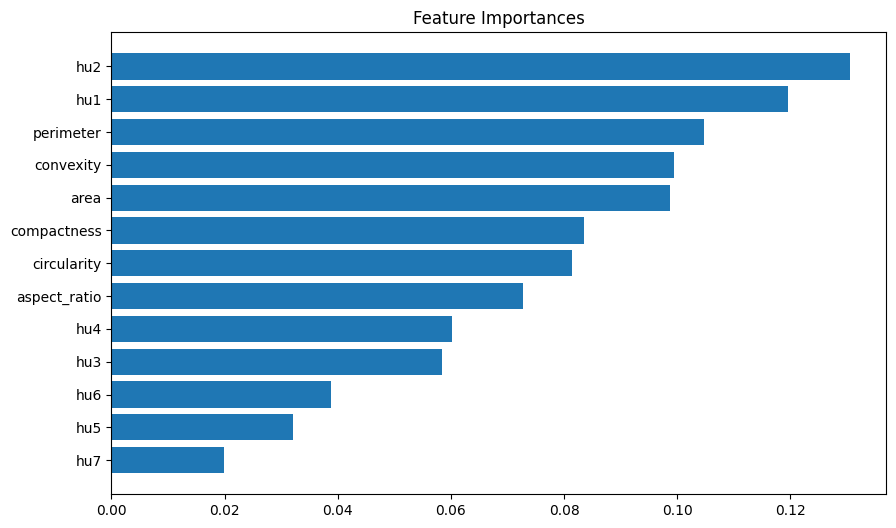

In [289]:
importances = rf.feature_importances_
feature_names = X_train_scaled.columns

feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_imp_df['Feature'], feature_imp_df['Importance'])
plt.gca().invert_yaxis()
plt.title("Feature Importances")
plt.show()